In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [12]:
from Modules.scraping import *
from Modules.supportFunctions import *
from Modules.Growth_curve_fitting import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dat = scrap_covid_data()

# START scraping
### Requesting url nr 1
### Requesting url nr 2
### Requesting url nr 3
# END scraping


In [6]:
data = cut_down(dat)

In [20]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

In [21]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

### Plot growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

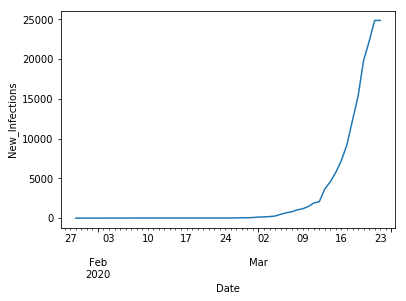

In [22]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].iloc[1:].plot()
ax.set_ylabel('New_Infections')

### Plot log of growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

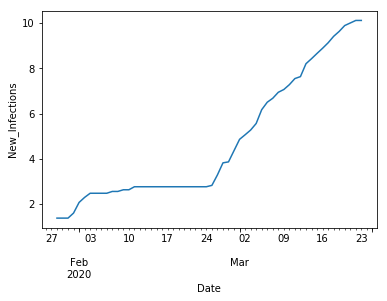

In [38]:
fig, ax = plt.subplots()
np.log(DE.loc[:,'Infected'].iloc[1:]).plot()
ax.set_ylabel('New_Infections')

### Analyse the stationarity of the time series 

In [82]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[1:])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[1:])[1])

AdFuller: 0.14757013449560769
KPSS: 0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Indicates a AR 1 Model


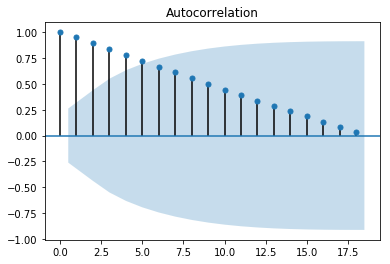

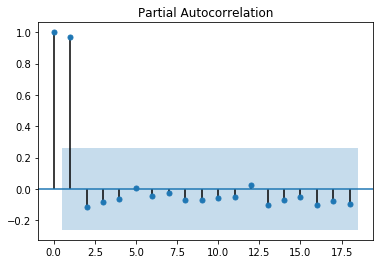

In [84]:
plot_acf(np.log(DE.loc[:,'Infected'])[1:])
plot_pacf(np.log(DE.loc[:,'Infected'])[1:])

### Fit ARIMA model with Auto ARIMA 

In [86]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[1:], start_p=0, start_q=0,
                           max_p=1, max_q=1, m=1,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0); AIC=277.811, BIC=281.861, Fit time=0.010 seconds
Fit ARIMA: order=(1, 0, 0); AIC=8.443, BIC=14.519, Fit time=0.148 seconds
Fit ARIMA: order=(0, 0, 1); AIC=209.058, BIC=215.134, Fit time=0.061 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.243 seconds
8.44321267852095


### Forecasting 

In [87]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[1:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=3)
#Back transformation
train, test, future_forecast = np.exp(train), np.exp(test) , np.exp(future_forecast)
print(future_forecast)

[19705.27274286 19563.80853173 19423.59449448]


In [88]:
future_forecast = pd.Series(future_forecast, index= test.index)
test_series = train.append(test)
forecast_series = train.append(future_forecast)

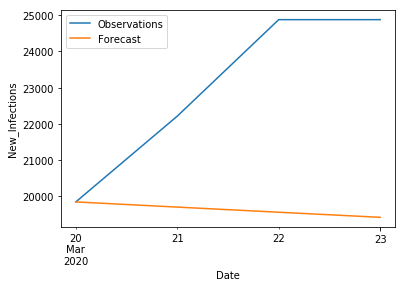

In [89]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

In [ ]:
fig, ax = plt.subplots()
test_series.loc['2020-03-01':].plot()
forecast_series.loc['2020-03-01':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

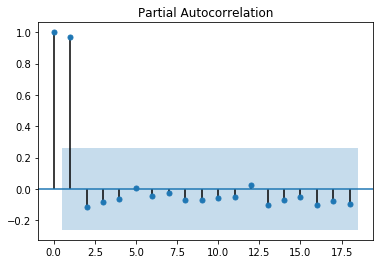

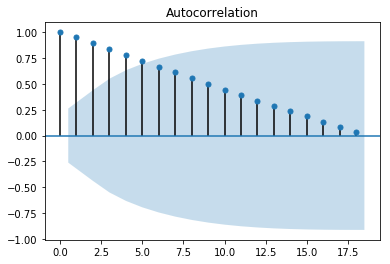

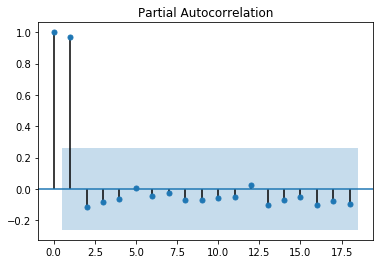